# Credit Card Fraud Detection

This notebook implements a state-of-the-art approach for credit card fraud detection, specifically designed for highly imbalanced datasets.


### Import the libraries

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

### Load and analyse the dataset

In [40]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [43]:
# Count the occurrences of each class
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [ ]:
# Plot class distribution
class_counts = df['Class'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 7.5))
bars = plt.bar(['Legitimate (0)', 'Fraudulent (1)'], class_counts, color=['green', 'red'])
plt.title('Distribution of Legitimate vs Fraudulent Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')

# Add count and percentage labels on top of each bar
total = class_counts.sum()
for bar in bars:
    height = bar.get_height()
    percentage = (height / total) * 100
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:,}\n({percentage:.2f}%)',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Prepare data for training

In [45]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

In [46]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Create and train the model

#### Create model pipeline

We'll create a pipeline that combines preprocessing steps with our model. This approach ensures that all steps are applied consistently to both training and testing data, preventing data leakage. Here's a breakdown of each step in our pipeline:

1. **StandardScaler**:
   - This step normalizes all features to have zero mean and unit variance.

2. **SMOTE (Synthetic Minority Over-sampling Technique)**:
   - This addresses the class imbalance problem by creating synthetic examples of the minority class (fraudulent transactions).
   - We set `sampling_strategy=0.1`, meaning it will create synthetic samples until the minority class is 10% of the majority class.
   - This helps prevent the model from being overly biased towards the majority class.

3. **RandomUnderSampler**:
   - After SMOTE, we apply undersampling to reduce the majority class (non-fraudulent transactions).
   - `sampling_strategy=0.5` means it will reduce the majority class until it's twice the size of the minority class.
   - This further balances our dataset while keeping a realistic ratio between classes.

4. **RandomForestClassifier**:
   - Our chosen model for classification.
   - They're effective for fraud detection due to their ability to handle non-linear relationships and feature interactions.
   - We're using 100 trees (`n_estimators=100`) in our forest.

By using this pipeline, we ensure that:
- Data scaling is applied correctly without leaking information from the test set.
- The class imbalance is addressed in a way that doesn't introduce bias into our model evaluation.
- Our preprocessing steps and model are treated as a single unit, making it easier to apply to new data.


In [47]:
# Create a pipeline for preprocessing and model training
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

#### Train the model

In [48]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('classifier', RandomForestClassifier(random_state=42))])

### Evaluate the model performance

In [49]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [50]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.89      0.78        98

    accuracy                           1.00     56962
   macro avg       0.85      0.94      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [51]:
# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[56826    38]
 [   11    87]]


In [52]:
# Calculate and print the AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")


AUC-ROC Score: 0.9760


In [53]:
# Feature importance
feature_importance = pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))


Top 10 Most Important Features:
   feature  importance
14     V14    0.197920
10     V10    0.124242
12     V12    0.105609
17     V17    0.091863
4       V4    0.085594
16     V16    0.059881
11     V11    0.056461
3       V3    0.051092
2       V2    0.036012
9       V9    0.027667


Interestingly, 'Time' and 'Amount' don't appear in the top 10. This suggests that the PCA-transformed features capture more relevant information for fraud detection than these raw features.

### Visualize results

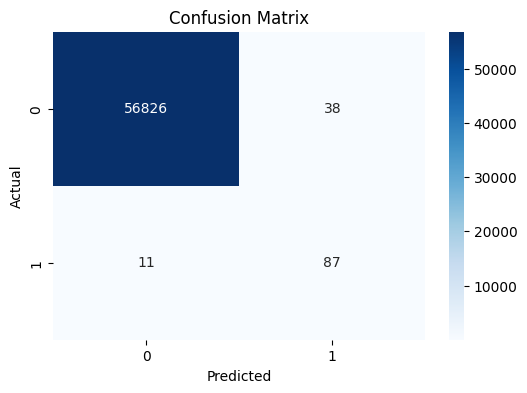

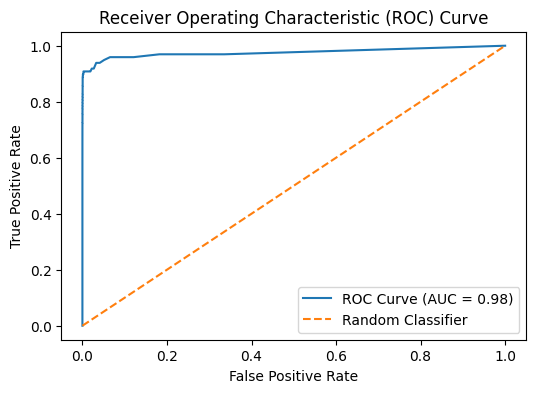

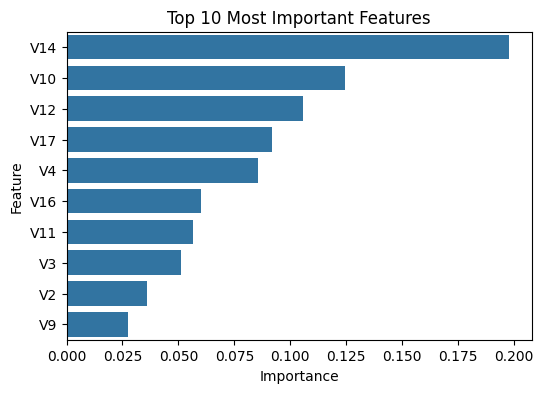

In [59]:
# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Feature Importance
feature_importance = pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()